## Imports

In [ ]:
!pip install pycaret-ts-alpha
!conda install -c conda-forge brotlipy
!pip install jupyterlab
!pip install nodejs
!conda install bottleneck
!pip install pymannkendall

In [1]:
# sktime
from sktime.forecasting.exp_smoothing import ExponentialSmoothing as ExponentialSmoothing_sktime
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.compose import MultiplexForecaster, AutoEnsembleForecaster, ColumnEnsembleForecaster, DirRecTabularRegressionForecaster, DirRecTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster, DirectTimeSeriesRegressionForecaster, EnsembleForecaster, StackingForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.croston import Croston
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster

from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteScaledError, mean_absolute_percentage_error
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

import matplotlib.pyplot as plt

import warnings

import sys
sys.path.append('../../src/')
from functions import *

def plot_sktime_results(train, test, scores_expanding, predictions_test, method, fh, preprocess, linewidth = 2, axis_labelsize = 12, legend_text_size = 15):
    df = scores_expanding.loc[(scores_expanding['Method'] == method)&(scores_expanding['Forecasting Horizon'] == fh)&(scores_expanding['Preprocess'] == preprocess)]
    fig, ax = plt.subplots(2, 1, figsize=(25, 10))
    ax[0].plot(train['datetime'], train[target], label='train', linewidth=linewidth, color='black')
    ax[0].plot(test['datetime'], test[target], label='test', linewidth=linewidth, color='blue')
    ax[0].plot(predictions_test['datetime'], predictions_test[f'{method}_{preprocess}'], label='forecasts', linewidth=linewidth, color='magenta');
    ax[0].legend(prop={'size': legend_text_size})
    ax[0].tick_params(axis='x', which='major', labelsize=axis_labelsize)
    ax[0].tick_params(axis='y', which='major', labelsize=axis_labelsize)
    ax[0].set_title(f"RMSE: {df['RMSE'].values[0]:.3f}, MASE: {df['MASE'].values[0]:.1f}, sMAPE: {df['sMAPE'].values[0]:.3f}", fontsize = 15, loc='center')

    ax[1].plot(test['datetime'], test[target], label='test', linewidth=linewidth, color='blue')
    ax[1].plot(predictions_test['datetime'], predictions_test[f'{method}_{preprocess}'], label='forecasts', linewidth=linewidth, color='magenta');
    ax[1].legend(prop={'size': legend_text_size})
    ax[1].tick_params(axis='x', which='major', labelsize=axis_labelsize)
    ax[1].tick_params(axis='y', which='major', labelsize=axis_labelsize)

## Read Data

In [2]:
dataset_name = 'Satellite'
data, frequency_yearly_period, freq_sktime = read_file(dataset_name, data_path='H:/My Drive/PhD/ECOSCOPE/time-series-forecasting-waves/data/')

Column 'date' was removed from Satellite.


In [3]:
data

,sla,ugosa,vgosa,err_ugosa,err_vgosa,adt,ugos,vgos
datetime,,,,,,,,
1993-01-01,-0.000316,-0.042639,0.021684,0.032655,0.038690,0.329958,-0.034710,0.005781
1993-02-01,-0.025014,-0.027007,-0.034014,0.033504,0.038207,0.305261,-0.019082,-0.049918
1993-03-01,-0.039558,0.022274,0.010235,0.032903,0.038090,0.290710,0.030203,-0.005668
1993-04-01,-0.062297,-0.057400,-0.029813,0.032583,0.038300,0.267980,-0.049467,-0.045723
1993-05-01,-0.045255,0.090942,-0.016448,0.032358,0.038768,0.285023,0.098865,-0.032352
...,...,...,...,...,...,...,...,...
2020-08-01,0.081081,-0.167006,0.030768,0.031016,0.036342,0.411352,-0.159061,0.014868
2020-09-01,0.109623,-0.083850,0.042430,0.030990,0.036527,0.439900,-0.075940,0.026523
2020-10-01,0.137674,0.044274,-0.005913,0.030810,0.036587,0.467961,0.052197,-0.021819


In [4]:
print(data.columns)

Index(['sla', 'ugosa', 'vgosa', 'err_ugosa', 'err_vgosa', 'adt', 'ugos',
       'vgos'],
      dtype='object')


## Initializations

In [5]:
# ONLY FOR SKTIME
# keep datetime as a column for plots
data['datetime'] = data.index
data.index = pd.PeriodIndex(data.index, freq=freq_sktime)

# split data
train, test, valid, train_without_valid, train_test_split_date, train_valid_split_date = train_valid_test_split(dataset_name, data)

train datetime margins              : 1993-01 - 2017-12.     Total samples: 300 (89.3%)
test datetime margins               : 2018-01 - 2020-12.     Total samples: 36 (10.7%)
valid datetime margins              : 2015-01 - 2017-12.     Total samples: 36 (10.7%)
train_without_valid datetime margins: 1993-01 - 2014-12.     Total samples: 264 (78.6%)


In [6]:
# define TARGET
target = 'err_vgosa'

# define forecastin horizon
fh=1

# save prediction in a df. a column per method
predictions_test = pd.DataFrame()
predictions_test['datetime'] = test['datetime']
predictions_test['true_values'] = test[target]

# expanding window to fit test data
cv = ExpandingWindowSplitter(step_length=1, fh=fh, initial_window=train.shape[0])

# define metrics
rmse = MeanSquaredError(square_root=True)
mase = MeanAbsoluteScaledError()
smape = mean_absolute_percentage_error
# keep track of scores, per method and fh
scores_expanding = pd.DataFrame(columns=['Method', 'Forecasting Horizon', 'Runtime', 'RMSE'])

In [7]:
# define forecasters
forecaster_dict = {
    'NaiveForecaster': NaiveForecaster(strategy='last', sp=frequency_yearly_period),
    'ExponentialSmoothing_sktime_simple': ExponentialSmoothing_sktime(),
    'ExponentialSmoothing_sktime_damped': ExponentialSmoothing_sktime(trend='add', damped_trend=True),
    'ThetaForecaster': ThetaForecaster(deseasonalize=False),
    'AutoARIMA': AutoARIMA(sp=frequency_yearly_period, stationary=False, suppress_warnings=True),
    'AutoETS': AutoETS(auto=True, n_jobs=-1, sp=frequency_yearly_period),
    'BATS': BATS(sp=frequency_yearly_period, show_warnings=False, n_jobs=-1),
    'TBATS': TBATS(sp=frequency_yearly_period, show_warnings=False, n_jobs=-1)
                   }
# DirectTabularRegressionForecaster
# AutoEnsembleForecaster, StackingForecaster

## Modeling

In [8]:
method = 'AutoETS'
preprocess = False

forecaster =  AutoETS(auto=True, n_jobs=-1, sp=frequency_yearly_period)

df = evaluate_sktime(forecaster=forecaster, y=data[target], cv=cv, return_data=True, scoring=rmse, 
                     preprocess=preprocess, frequency_yearly_period=frequency_yearly_period)

# save predictions in a df
forecasts = [i.values[0] for i in df['y_pred'].values]
for i in range(fh-1):
    forecasts = np.insert(forecasts, 0, np.nan)
predictions_test[f'{method}_{preprocess}'] = forecasts

total_runtime = np.sum(df['fit_time']) + np.sum(df['pred_time'])
scores_expanding = scores_expanding.append({
    'Method': method, 
    'Forecasting Horizon': fh, 
    'Preprocess': preprocess,
    'Runtime': total_runtime, 
    'RMSE': rmse(df['y_test'], df['y_pred']),
    'MASE': mase(df['y_test'], df['y_pred'], y_train=df['y_train'][0]),
    'sMAPE': smape(df['y_test'], df['y_pred'], symmetric=True),
}, ignore_index=True)
# TODO: save predictions_test and scores_expanding

36it [00:17,  2.01it/s]


In [9]:
predictions_test.head()

,datetime,true_values,AutoETS_False
datetime,,,
2018-01,2018-01-01,0.036445,0.036460
2018-02,2018-02-01,0.036536,0.036454
2018-03,2018-03-01,0.036632,0.036486
2018-04,2018-04-01,0.036573,0.036542
2018-05,2018-05-01,0.036490,0.036554


In [10]:
scores_expanding

,Method,Forecasting Horizon,Runtime,RMSE,MASE,Preprocess,sMAPE
0,AutoETS,1,17.714676,0.000427,0.00378,0.0,0.008003


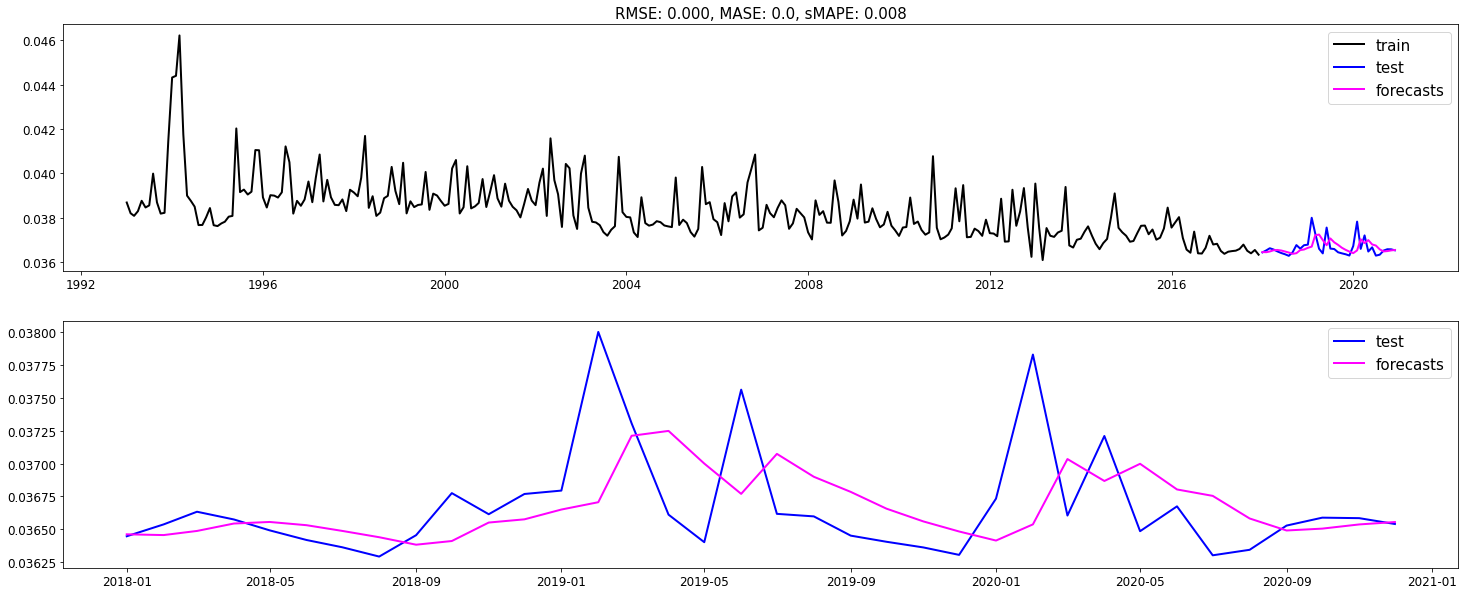

In [11]:
plot_sktime_results(train, test, scores_expanding, predictions_test, method=method, fh=fh, preprocess=preprocess,
                    linewidth = 2, axis_labelsize = 12, legend_text_size = 15)